In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, './util')
import vcpi_util


In [3]:
print(torch.__version__)

2.2.1+cu121


In [4]:
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, scheduler, early_stopper, save_prefix = 'model'):

    history = {}

    history['val_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, _) in tqdm(enumerate(train_loader, 0)):
            
            inputs = inputs.to(device)
    
            outputs = model(inputs)
    
            loss = loss_fn(outputs, inputs)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()
     
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i,_ in val_loader:
                i = i.to(device)
                o = model(i)
                
                #with torch.no_grad():
                val_loss += loss_fn(o, i).cpu().detach().numpy()


        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Val Loss: {val_loss:0.6f}; Elapsed time: {(stop_time - start_time):0.4f}')

        history['val_loss'].append(val_loss)
        history['loss'].append(epoch_loss)
 
        ###### Saving ######
        if val_loss < best_val_loss:
           
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'history': history,
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_best.pt')
            best_val_loss = val_loss

        if early_stopper(val_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)



class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):

        self.patience = patience 
        self.min_delta = min_delta

        self.min_val_loss = float('inf')

    def __call__(self, val_loss):

        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False
    
from matplotlib import colors

def plot_scatter(x,y,targets):
    cmap = colors.ListedColormap(['black', 'darkred', 'darkblue', 
                                  'darkgreen', 'yellow', 'brown', 
                                  'purple', 'lightgreen', 'red', 'lightblue'])
    bounds=[0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5,8.5,9.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    plt.figure(figsize=(10,10))
    plt.scatter(x, y, c = targets, cmap=cmap, s = 1, norm=norm)
    plt.colorbar()

    plt.show()


## Configuration

In [5]:
HEIGHT = 28
WIDTH = 28
NUM_CHANNELS = 1
BATCH_SIZE = 32
LATENT_SPACE_DIM = 2

MODEL_PATH = 'autoencoder_models'

train_online = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [6]:
from importlib import reload
reload(vcpi_util)

<module 'vcpi_util' from 'c:\\Users\\paulo\\Desktop\\Visão por computador\\AULA 11\\./util\\vcpi_util.py'>

## Load and prepare MNIST dataset

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor()]) 

full_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = BATCH_SIZE)

test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:24<00:00, 399836.88it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 28881/28881 [00:00<00:00, 187939.56it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 1648877/1648877 [00:01<00:00, 879124.28it/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



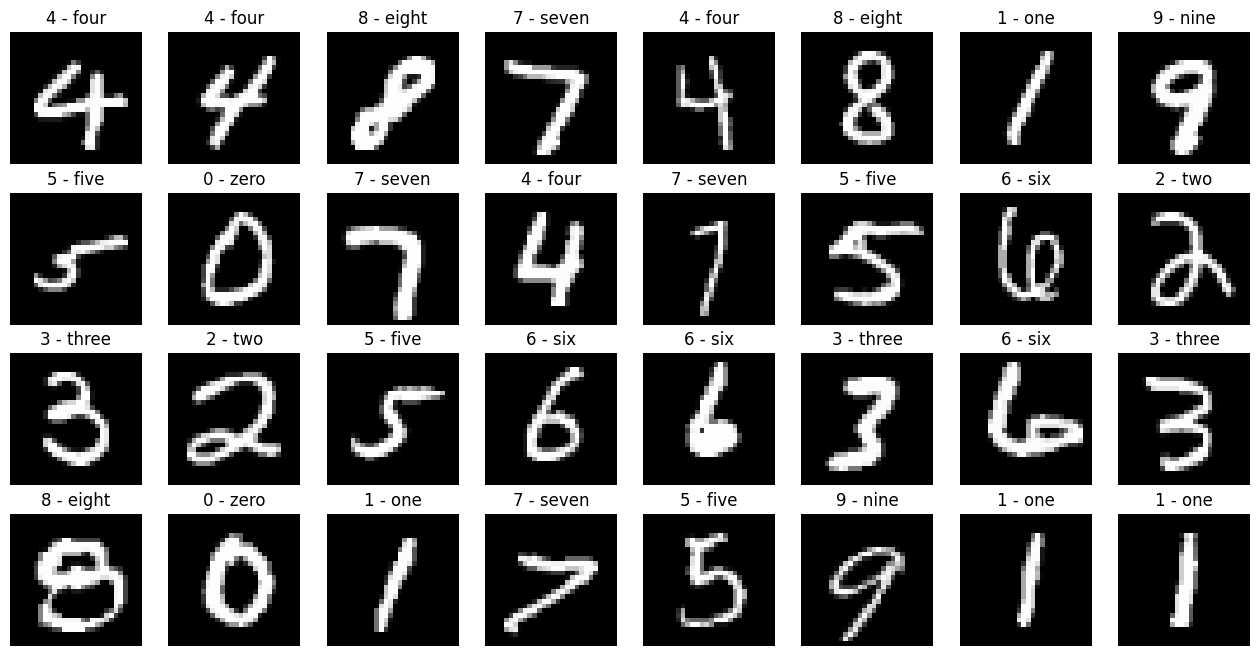

<Figure size 640x480 with 0 Axes>

In [8]:
images, targets = next(iter(train_loader))

vcpi_util.show_images(4,8, images, targets, full_dataset.classes) 

In [20]:
import torch

class Autoencoder(torch.nn.Module):
    def __init__(self, latent_space_dim):
        super(Autoencoder, self).__init__()

        # Encoder
        self.econv1 = torch.nn.Conv2d(1, 32, 3, 2)
        self.erelu1 = torch.nn.ReLU()
        self.eb1 = torch.nn.BatchNorm2d(32)

        self.econv2 = torch.nn.Conv2d(32, 64, 3, 2)
        self.erelu2 = torch.nn.ReLU()
        self.eb2 = torch.nn.BatchNorm2d(64)

        self.efc1 = torch.nn.Linear(3136, latent_space_dim)

        # Decoder
        self.dfc1 = torch.nn.Linear(latent_space_dim, 3136)  

        self.dconv1 = torch.nn.ConvTranspose2d(
            64, 32, 3, 2, padding=1, output_padding=1
        )
        self.drelu1 = torch.nn.ReLU()
        self.db1 = torch.nn.BatchNorm2d(32)

        self.dconv2 = torch.nn.ConvTranspose2d(
            32, 1, 3, 2, padding=1, output_padding=1
        )
        self.sig = torch.nn.Sigmoid()

    def encoder(self, x):
        x = torch.nn.functional.pad(x, (0, 1, 0, 1))
        x = self.econv1(x)
        x = self.erelu1(x)
        x = self.eb1(x)

        x = torch.nn.functional.pad(x, (0, 1, 0, 1))
        x = self.econv2(x)
        x = self.erelu2(x)
        x = self.eb2(x)

        x = torch.flatten(x, 1)
        x = self.efc1(x)
        return x

    def decoder(self, x):
        x = self.dfc1(x)
        x = x.reshape(-1, 64, 7, 7)

        x = self.dconv1(x)
        x = self.drelu1(x)
        x = self.db1(x)

        x = self.dconv2(x)
        x = self.sig(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [21]:
AE = Autoencoder(LATENT_SPACE_DIM)
AE.to(device)

torchinfo.summary(AE, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [32, 1, 28, 28]           --
├─Conv2d: 1-1                            [32, 32, 14, 14]          320
├─ReLU: 1-2                              [32, 32, 14, 14]          --
├─BatchNorm2d: 1-3                       [32, 32, 14, 14]          64
├─Conv2d: 1-4                            [32, 64, 7, 7]            18,496
├─ReLU: 1-5                              [32, 64, 7, 7]            --
├─BatchNorm2d: 1-6                       [32, 64, 7, 7]            128
├─Linear: 1-7                            [32, 2]                   6,274
├─Linear: 1-8                            [32, 3136]                9,408
├─ConvTranspose2d: 1-9                   [32, 32, 14, 14]          18,464
├─ReLU: 1-10                             [32, 32, 14, 14]          --
├─BatchNorm2d: 1-11                      [32, 32, 14, 14]          64
├─ConvTranspose2d: 1-12                  [32, 1, 28, 28]           28

In [24]:
loss_fn = torch.nn.MSELoss()

opt = torch.optim.Adam(AE.parameters(), lr =1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=3)
early_stop = Early_Stopping(9)

In [26]:
history = train(AE, train_loader, val_loader, 100, loss_fn, opt, scheduler,early_stop,f'auto_{LATENT_SPACE_DIM}')

1500it [00:13, 110.22it/s]


Epoch: 000; Loss: 0.002029; Val Loss: 0.001706; Elapsed time: 15.8463


1500it [00:13, 113.02it/s]


Epoch: 001; Loss: 0.001672; Val Loss: 0.001633; Elapsed time: 15.3958


1500it [00:12, 116.92it/s]


Epoch: 002; Loss: 0.001607; Val Loss: 0.001575; Elapsed time: 15.0405


1500it [00:13, 109.91it/s]


Epoch: 003; Loss: 0.001550; Val Loss: 0.001522; Elapsed time: 15.8865


1500it [00:14, 100.25it/s]


Epoch: 004; Loss: 0.001511; Val Loss: 0.001508; Elapsed time: 17.1973


1500it [00:13, 113.74it/s]


Epoch: 005; Loss: 0.001483; Val Loss: 0.001468; Elapsed time: 15.5781


1500it [00:12, 119.13it/s]


Epoch: 006; Loss: 0.001464; Val Loss: 0.001447; Elapsed time: 14.6207


1500it [00:12, 119.35it/s]


Epoch: 007; Loss: 0.001449; Val Loss: 0.001439; Elapsed time: 14.5305


1500it [00:13, 109.89it/s]


Epoch: 008; Loss: 0.001438; Val Loss: 0.001432; Elapsed time: 15.9583


1500it [00:12, 115.93it/s]


Epoch: 009; Loss: 0.001428; Val Loss: 0.001419; Elapsed time: 14.8984


1500it [00:12, 115.88it/s]


Epoch: 010; Loss: 0.001421; Val Loss: 0.001412; Elapsed time: 15.0990


1500it [00:13, 114.98it/s]


Epoch: 011; Loss: 0.001414; Val Loss: 0.001414; Elapsed time: 15.0592


1500it [00:12, 117.08it/s]


Epoch: 012; Loss: 0.001408; Val Loss: 0.001406; Elapsed time: 15.0386


1500it [00:13, 114.68it/s]


Epoch: 013; Loss: 0.001402; Val Loss: 0.001403; Elapsed time: 15.1199


1500it [00:12, 115.94it/s]


Epoch: 014; Loss: 0.001397; Val Loss: 0.001397; Elapsed time: 14.9511


1500it [00:13, 113.62it/s]


Epoch: 015; Loss: 0.001392; Val Loss: 0.001393; Elapsed time: 15.3650


1500it [00:12, 115.42it/s]


Epoch: 016; Loss: 0.001388; Val Loss: 0.001393; Elapsed time: 15.0501


1500it [00:13, 113.96it/s]


Epoch: 017; Loss: 0.001385; Val Loss: 0.001386; Elapsed time: 15.3093


1500it [00:12, 115.90it/s]


Epoch: 018; Loss: 0.001380; Val Loss: 0.001392; Elapsed time: 15.0808


1500it [00:12, 116.90it/s]


Epoch: 019; Loss: 0.001377; Val Loss: 0.001378; Elapsed time: 15.0068


1500it [00:12, 116.33it/s]


Epoch: 020; Loss: 0.001373; Val Loss: 0.001381; Elapsed time: 15.0951


1500it [00:13, 112.66it/s]


Epoch: 021; Loss: 0.001371; Val Loss: 0.001376; Elapsed time: 15.4836


1500it [00:12, 116.08it/s]


Epoch: 022; Loss: 0.001367; Val Loss: 0.001372; Elapsed time: 15.0929


1500it [00:12, 117.27it/s]


Epoch: 023; Loss: 0.001364; Val Loss: 0.001369; Elapsed time: 14.7856


1500it [00:12, 117.27it/s]


Epoch: 024; Loss: 0.001362; Val Loss: 0.001371; Elapsed time: 14.9678


1500it [00:13, 113.14it/s]


Epoch: 025; Loss: 0.001358; Val Loss: 0.001364; Elapsed time: 15.6524


1500it [00:13, 111.06it/s]


Epoch: 026; Loss: 0.001356; Val Loss: 0.001361; Elapsed time: 15.5582


1500it [00:14, 103.44it/s]


Epoch: 027; Loss: 0.001353; Val Loss: 0.001360; Elapsed time: 16.8137


1500it [00:14, 102.87it/s]


Epoch: 028; Loss: 0.001351; Val Loss: 0.001364; Elapsed time: 16.9614


1500it [00:12, 116.34it/s]


Epoch: 029; Loss: 0.001348; Val Loss: 0.001357; Elapsed time: 15.1998


1500it [00:13, 114.57it/s]


Epoch: 030; Loss: 0.001347; Val Loss: 0.001351; Elapsed time: 15.1403


1500it [00:12, 116.86it/s]


Epoch: 031; Loss: 0.001344; Val Loss: 0.001354; Elapsed time: 15.0182


1500it [00:12, 117.84it/s]


Epoch: 032; Loss: 0.001342; Val Loss: 0.001354; Elapsed time: 14.8797


1500it [00:12, 117.22it/s]


Epoch: 033; Loss: 0.001340; Val Loss: 0.001352; Elapsed time: 14.8528


1500it [00:12, 115.74it/s]


==> Learning rate updated:  0.001  ->  0.0001
Epoch: 034; Loss: 0.001339; Val Loss: 0.001353; Elapsed time: 15.0076


1500it [00:12, 117.91it/s]


Epoch: 035; Loss: 0.001312; Val Loss: 0.001331; Elapsed time: 14.8882


1500it [00:13, 114.62it/s]


Epoch: 036; Loss: 0.001308; Val Loss: 0.001330; Elapsed time: 15.3075


1500it [00:12, 116.61it/s]


Epoch: 037; Loss: 0.001307; Val Loss: 0.001330; Elapsed time: 14.8527


1500it [00:12, 115.57it/s]


Epoch: 038; Loss: 0.001306; Val Loss: 0.001330; Elapsed time: 14.9747


1500it [00:12, 118.00it/s]


Epoch: 039; Loss: 0.001305; Val Loss: 0.001330; Elapsed time: 14.8733


1500it [00:12, 117.18it/s]


Epoch: 040; Loss: 0.001304; Val Loss: 0.001330; Elapsed time: 15.0185


1500it [00:12, 117.91it/s]


Epoch: 041; Loss: 0.001304; Val Loss: 0.001329; Elapsed time: 14.8677


1500it [00:12, 117.02it/s]


Epoch: 042; Loss: 0.001303; Val Loss: 0.001330; Elapsed time: 14.9529


1500it [00:12, 115.62it/s]


Epoch: 043; Loss: 0.001302; Val Loss: 0.001330; Elapsed time: 14.9794


1500it [00:12, 117.95it/s]


Epoch: 044; Loss: 0.001302; Val Loss: 0.001329; Elapsed time: 14.8997


1500it [00:12, 118.26it/s]


Epoch: 045; Loss: 0.001302; Val Loss: 0.001329; Elapsed time: 14.8850
Early stopping!
Finished Training


In [27]:

reload = torch.load('auto_2_best.pt')
AE.load_state_dict(reload['model'])

<All keys matched successfully>

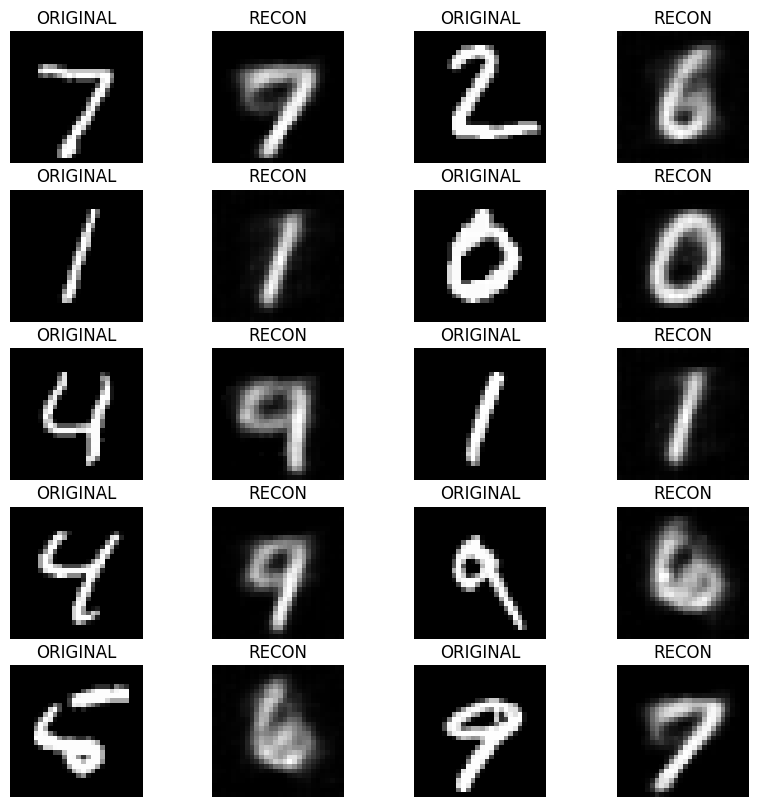

In [33]:
def show_preds(set1, set2, count):
    columns = 4
    rows = int(count * 2/ columns) +1
    plt.figure(figsize=(count, 2 * rows))

    for n in range(count):
        ax = plt.subplot(rows, columns, n * 2+ 1)
        plt.title('ORIGINAL')
        plt.imshow(np.transpose(set1[n].numpy(), (1,2,0)), cmap= plt.cm.gray)
        plt.axis('off')

        ax = plt.subplot(rows, columns, n * 2+ 2)
        plt.title('RECON')
        plt.imshow(np.transpose(set2[n].cpu().detach().numpy(), (1,2,0)), cmap= plt.cm.gray)
        plt.axis('off')

i, _ = next(iter(test_loader))
recon = AE(i.to(device))

show_preds(i, recon, 10)



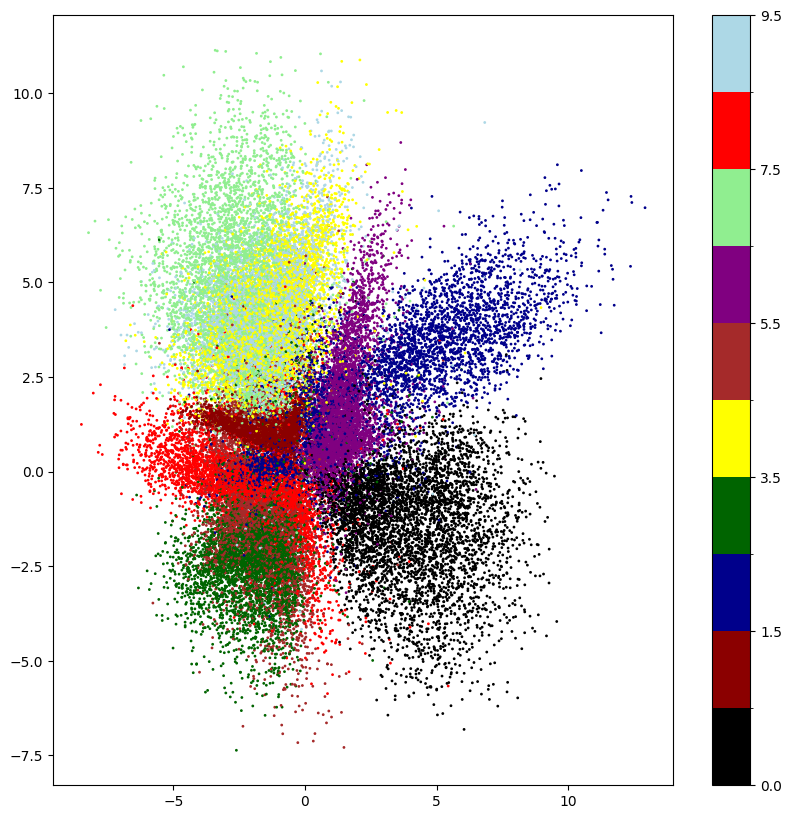

In [35]:
encoded = []
targets = []

for i, t in train_loader:
    encoded.extend(AE.encoder(i.to(device)).cpu().detach().numpy())
    targets.extend(t)

x = np.array(encoded)[:,0]
y = np.array(encoded)[:,1]

plot_scatter(x, y, targets)

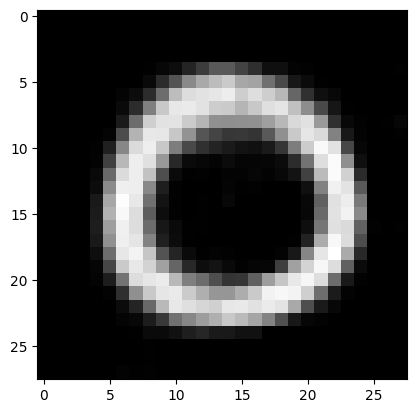

In [43]:
pred = AE.decoder(torch.Tensor([[5, -4]]).to(device))

plt.imshow(np.transpose(pred[0].cpu().detach().numpy(), (1, 2, 0)), cmap = plt.cm.gray)

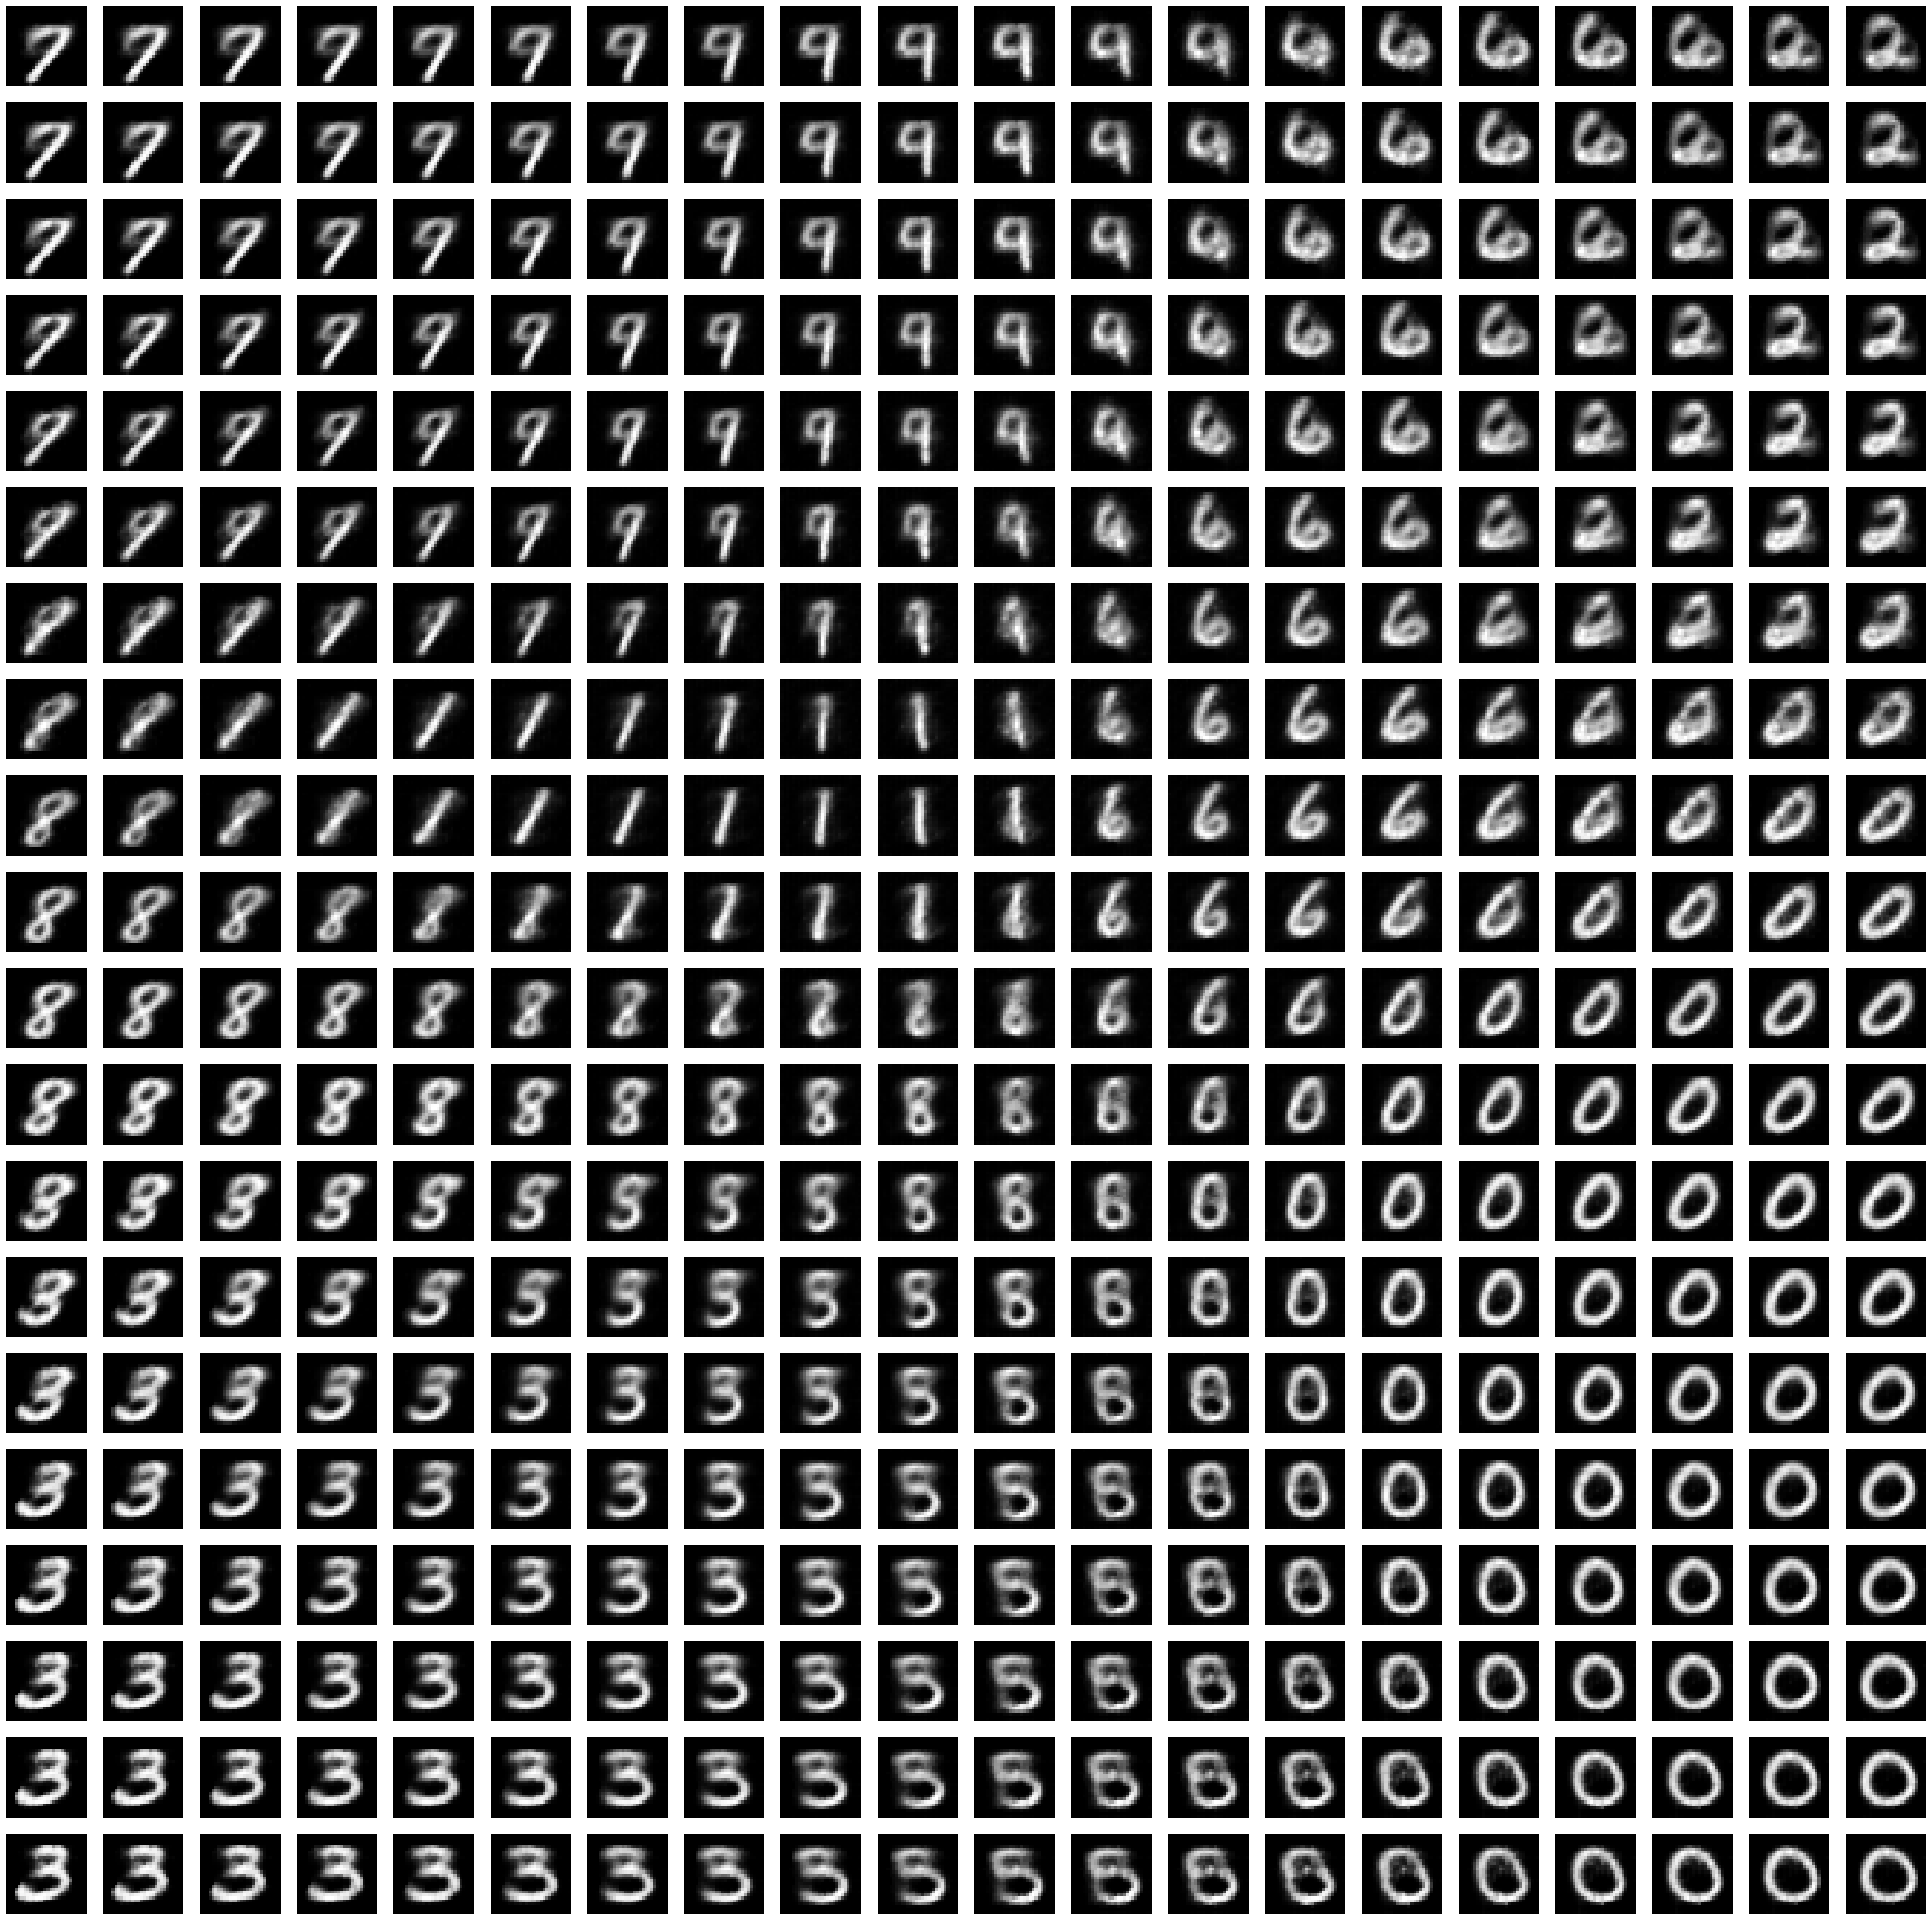

<Figure size 640x480 with 0 Axes>

In [46]:
limit = 5
steps = 20

step = (2*limit)/steps
vector_generation = [[-limit + j * step, limit - i * step] for i in range(steps) for j in range(steps)]

predictions = AE.decoder(torch.Tensor(vector_generation).to(device))

vcpi_util.show_predicted_images(steps, steps, predictions.cpu().detach(),10)

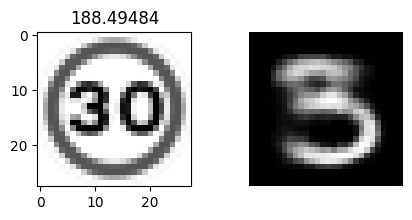

In [55]:
# Anomaly detection
import glob


def show_anomaly_samples(image, recon, err):
    plt.figure(figsize=(5, 2))

    alx = plt.subplot(1, 2, 1)

    plt.imshow(image, cmap="gray")
    plt.title(str(err))
    ax = plt.subplot(1,2,2)
    plt.imshow(recon, cmap='gray')
    plt.axis('off')

def anomalyDetection(image_path):
    files = glob.glob(f'{image_path}/*.jpg')
    for f in files:
        img = Image.open(f).convert('L').resize((28,28))
        data = transform(img).to(device).view(1,1,28,28)

        testing = AE(data)
        err = np.mean(img-testing.cpu().detach().numpy()**2)
        show_anomaly_samples(img, np.transpose(testing[0].cpu().detach().numpy(), (1,2,0)), err)

image_path = './anomaly'
anomalyDetection(image_path)

In [57]:
features = []
for i in range(train_set.__len__()):
    features.extend(AE.encoder(train_set[i][0].view(1,1,28,28).to(device)))

In [60]:
indexes = list(range(0, train_set.__len__()))
data = {'indexes':indexes, 'features': features}

def show_content_retrieval(train_X, top50):

    fig = plt.figure(figsize=(10, 50))
    for i in range(len(top50)):
        ax = plt.subplot(25,5,i+1)
        plt.imshow(np.transpose(train_X[top50[i][1]][0],(1,2,0)),cmap='gray')
        plt.title(f'{top50[i][0]:.3f}')
        plt.axis('off')

In [62]:
image_path = './anomaly/g_p9156.jpg'

img = Image.open(image_path).convert('L').resize((28,28))
img_tensor = transform(img).to(device).view(1,1,28,28)

dataLatent = AE.encoder(img_tensor).cpu().detach().numpy().squeeze()

In [63]:
results = []

for i in range(len(data['indexes'])):
    err = np.sum((dataLatent - data['features'][i].cpu().detach().numpy()) ** 2)
    err /= float(dataLatent.shape[0])

    results.append([err, i])

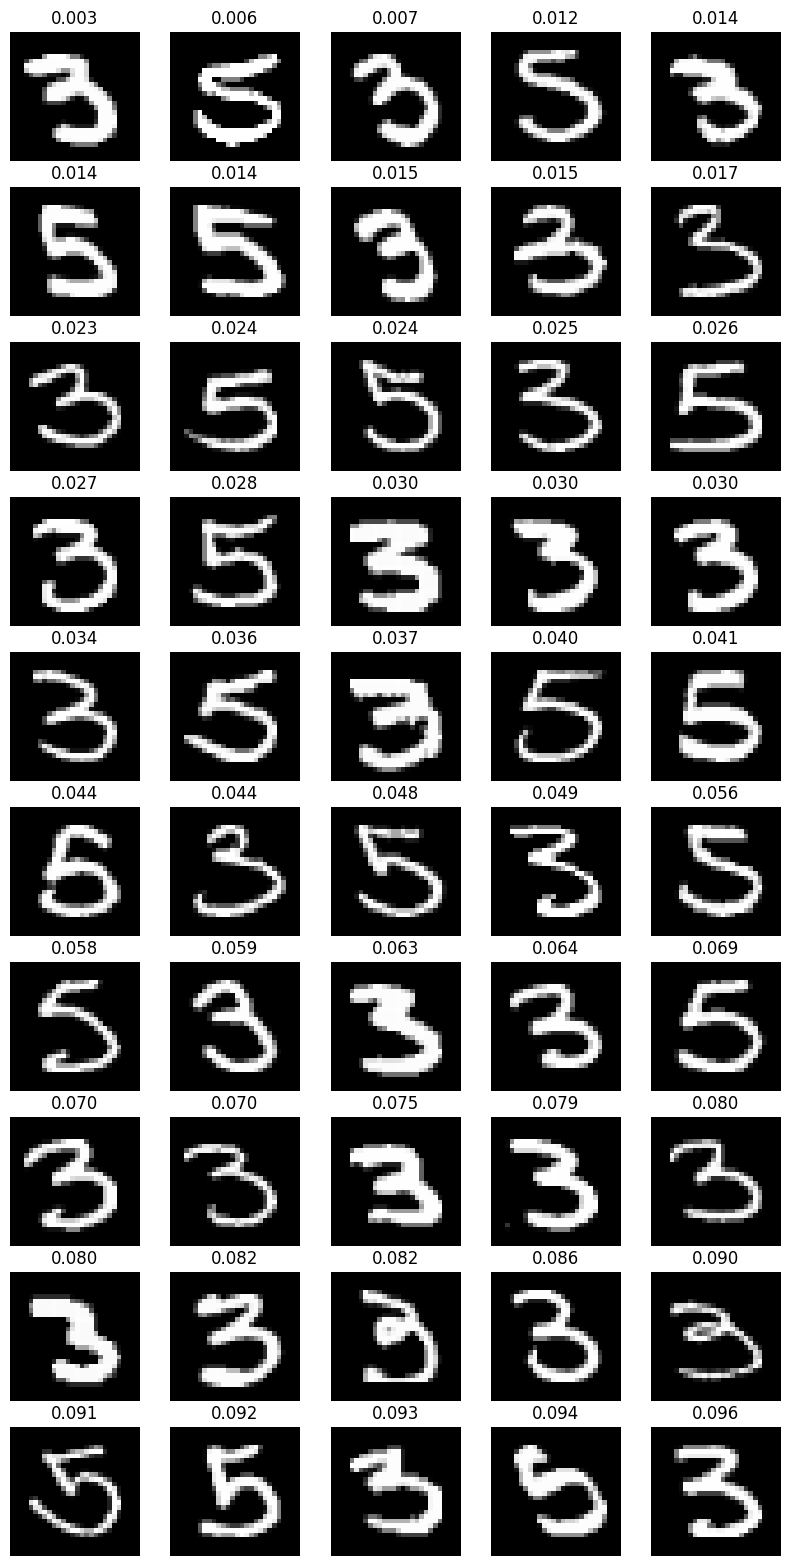

In [64]:
# Show similar images to the one that is passed
top50 = sorted(results)[:50]

show_content_retrieval(train_set, top50)